# Imports

In [96]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim.optimizer import Optimizer
from torchvision.models import DenseNet121_Weights
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import datetime
from sklearn.metrics import f1_score
from PIL import Image
import nibabel as nib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualisation

In [97]:
def view_nii_pic(nii_data: np.ndarray) -> None:
    for i in range(nii_data.shape[2]):
        cv2.imshow('slice', nii_data[:, :, i])
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def visualize_photo(img: np.ndarray, photo_title: str, *slices: int) -> None:
    print(f"Visualizing {photo_title}")
    plt.figure(figsize=(5 * len(slices), 5)) 
    
    for i, slice_num in enumerate(slices):
        plt.subplot(1, len(slices), i + 1)
        plt.title(f"photo Slice {slice_num}")
        plt.imshow(img[:, :, slice_num], cmap="gray")
        
    plt.tight_layout() 
    plt.show()
  
    
def visualize_photos(original: np.ndarray, segmented: np.ndarray, reference: np.ndarray, *slices: int) -> None:
    num_slices = len(slices)
    plt.figure(figsize=(15, 5 * num_slices))  # Adjust figure size based on the number of slices

    for i, slice_num in enumerate(slices):
        # Original slice
        plt.subplot(num_slices, 3, 3 * i + 1)
        plt.title(f"Original Slice {slice_num}")
        plt.imshow(original[:, :, slice_num], cmap="gray")
        
        # Segmented slice
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.title(f"Segmented Slice {slice_num}")
        plt.imshow(segmented[:, :, slice_num], cmap="gray")
        
        # Reference slice
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.title(f"Reference Slice {slice_num}")
        plt.imshow(reference[:, :, slice_num], cmap="gray")

    plt.tight_layout() 
    plt.show()
    
def plot_histogram(img: np.ndarray) -> None:
    plt.hist(img.ravel(), bins=256, range=(img.min()+1, img.max()-1), fc='k', ec='k')
    plt.axvline(x=-320, color='red', linestyle='--', linewidth=1.5)
    plt.show()

# Dataset

In [147]:
class AbdomenDataset(Dataset):
    def __init__(self, filepath: str, label_filepath: str, transform=None):
        self.transform = transform
        self.data: list = self._load_nii_gz_files(filepath)
        self.labels: list = self._load_labels_file(label_filepath)
        
        self.frames_list: list = []
        self.labels_list: list = []
        
        self.positive_count = 0
        
        for file_name, img in self.data:
            print(f"loading {file_name}")
            end, begin = self.labels[file_name]
            for i in range(0, img.shape[2]):
                self.frames_list.append(img[:, :, i])
                self.labels_list.append(1 if begin <= i <= end else 0)
                self.positive_count += self.labels_list[-1]
                
        print(f"Loaded {len(self.frames_list)} frames")
        
    def __len__(self) -> int:
        return len(self.frames_list)
    
    def __getitem__(self, idx: int) -> dict:
        img = self.frames_list[idx]
        label = float(self.labels_list[idx])
        
        img = torch.tensor(img).float().unsqueeze(0)
        img = self.transform(img)            
        return img.repeat(3, 1, 1), label
        
        
    def _load_labels_file(self, label_filepath: str) -> dict:
        labels: list = {}
        with open(label_filepath, 'r') as file:
            for line in file:
                file_name, end, begin = line.split()
                labels[file_name] = (int(end), int(begin))
        return labels
    
    def _load_nii_gz_files(self, filepath) -> list:
        data: list = []
        for file_name in os.listdir(filepath):
            if file_name.endswith('.nii.gz'):
                file_path = os.path.join(filepath, file_name)
                nii_img = nib.load(file_path)
                nii_data = nii_img.get_fdata()  # img as numpy array
                data.append((file_name, nii_data))
        return data
    
    
class AbdomenSingleDataset(Dataset):
    def __init__(self, filepath: str, filename: str, transform=None):
        self.transform = transform
        self.original_img: list = self._load_file(filepath, filename)
        self.frames_list: list = [self.original_img[:, :, i] for i in range(self.original_img.shape[2])]
        print(f"Loaded {len(self.frames_list)} frames")
        
    def __len__(self) -> int:
        return len(self.frames_list)
    
    def __getitem__(self, idx: int) -> dict:
        img = self.frames_list[idx]
        img = torch.tensor(img).float().unsqueeze(0)
        img = self.transform(img)            
        return img.repeat(3, 1, 1)
    
    def _load_file(self, filepath, filename) -> list:   
        f = os.path.join(filepath, filename)
        nii_img = nib.load(f)
        nii_data = nii_img.get_fdata()
        return nii_data
    

# Model

In [99]:
class AbdomenModel(nn.Module):
    def __init__(self) -> None:
        super(AbdomenModel, self).__init__()
        self.densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        self.freeze_densenet()
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(self.densenet.classifier.in_features, 1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def predict(self, x):
        x = self(x)
        return self.sigmoid(x)
    
    def forward(self, x):
        return self.densenet(x)
    
    def unfreeze_densenet(self) -> None:
        for param in self.densenet.parameters():
            param.requires_grad = True
    
    def freeze_densenet(self) -> None:
        for param in self.densenet.parameters():
            param.requires_grad = False

# Training loop

In [100]:
def training_loop(model: AbdomenModel, criterion: torch.nn.Module, optimizer: Optimizer, dataloader: dict, EPOCHS: int = 10):
    accuracy_history: list = []
    loss_history: list = []
    val_accuracy_history: list = []
    val_loss_history: list = []
    
    sigm = nn.Sigmoid()
    
    for epoch in range(EPOCHS):    
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for data in tqdm(dataloader['train']):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(dim=-1)
            outputs_sigm = sigm(outputs)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            preds = (outputs_sigm > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / len(dataloader['train'])
        train_accuracy = correct / total
        loss_history.append(train_loss)
        accuracy_history.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data in tqdm(dataloader['val']):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device).float()
                
                outputs = model(inputs).squeeze(dim=-1)
                outputs_sigm = sigm(outputs)
            
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                preds = (outputs_sigm > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss = val_loss / len(dataloader['val'])
        val_accuracy = val_correct / val_total
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)
        
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
    return model, [accuracy_history, loss_history, val_accuracy_history, val_loss_history]

# Train

In [119]:
transform_val = torchvision.transforms.Compose([
    lambda x: (x + 1024) / 3072,
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

transform = torchvision.transforms.Compose([
    lambda x: (x + 1024) / 3072,
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(40),
    torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

datasets = {
    "train": AbdomenDataset('data/train', 'data/oznaczenia.txt', transform=transform),
    "val": AbdomenDataset('data/val', 'data/oznaczenia.txt', transform=transform_val),
}

dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=8, shuffle=True),
    "val": DataLoader(datasets["val"], batch_size=8, shuffle=True),
}

loading 0003_1_.nii.gz
Loaded 207 frames


In [103]:
print(len(datasets['train']))
scaling_weight = (len(datasets['train']) - datasets['train'].positive_count) / datasets['train'].positive_count
print(scaling_weight)

4861
6.6191222570532915


In [104]:
model = AbdomenModel().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling_weight], device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [105]:
model, history = training_loop(model, criterion, optimizer, dataloaders, EPOCHS=5)
model.unfreeze_densenet()
model, history = training_loop(model, criterion, optimizer, dataloaders, EPOCHS=55)
torch.save(model.state_dict(), f"results/model_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{max(history[2])}.pt")

  1%|          | 7/608 [00:02<03:01,  3.32it/s]


KeyboardInterrupt: 

# Test

# Select Abdomen

In [134]:
def select_window_of_abdomen(list_of_probabilities: list) -> tuple[int, int]:
    # active = np.array(list_of_probabilities) > 0.1
    # active = active.astype(int)
    # print(active)
    
    # best_begin = 0
    # best_end = 0
    # best_value = 0
    
    # list_of_proba = np.array(list_of_probabilities)
    # list_of_proba_rev = 1 - list_of_proba
    
    # for start in range(len(list_of_probabilities)):
    #     for end in range(start, len(list_of_probabilities)):
    #         product = np.prod(list_of_probabilities[start:end])
    #         product_rev_rest = np.prod(list_of_proba_rev[end + 1:]) * np.prod(list_of_probabilities[:start])
    #         value = product * product_rev_rest
            
    #         if value > best_value:
    #             best_value = value
    #             best_begin = start
    #             best_end = end
                
    # return best_begin, best_end
    pass
    

def naive_abdomen_selection(list_of_probabilities: list) -> tuple[int, int]:
    size = 30
    
    max_value = float('-inf')
    l, r = 0, size
    
    for i in range(len(list_of_probabilities) - size):
        value = sum(list_of_probabilities[i:i + size])
        if value > max_value:
            max_value = value
            l, r = i, i + size
            
    return l, r
    

In [170]:
transform_val = torchvision.transforms.Compose([
    lambda x: (x + 1024) / 3072,
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])


def load_single_dataloaders(filepath: str) -> list:
    dataloaders = []
    for file_name in os.listdir(filepath):
        if file_name.endswith('.nii.gz'):
            dl = DataLoader(AbdomenSingleDataset(filepath, file_name, transform=transform_val))
            dataloaders.append((dl, file_name))
    
    return dataloaders

def load_labeled_scores(label_filepath: str) -> dict:
        labels: list = {}
        with open(label_filepath, 'r') as file:
            for line in file:
                file_name, end, begin = line.split()
                labels[file_name] = (int(end), int(begin))
        return labels

def get_prepared_outputs(filepath: str) -> list:
    model_path = "results/model_2024-12-10_18-43-51_0.9933460076045627.pt"
    model = AbdomenModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    sigm = nn.Sigmoid()
    outputs = []
    dataloaders = load_single_dataloaders(filepath)

    for dl, file_name in dataloaders:
        dl_output = []
        print("Processing files")
        for data in tqdm(dl):
            inputs = data
            inputs = inputs.to(device)
            fragment_outputs = model(inputs).squeeze(dim=-1)
            fragment_outputs_sigm = sigm(fragment_outputs)
            dl_output.append(fragment_outputs_sigm.tolist()[0])
        
        outputs.append((dl_output, file_name))
    
    
    return outputs
            
prepared_outputs = get_prepared_outputs('data/val')
  

/var/folders/q8/_wsl_9ys3zs1fzf1r5t3yzyw0000gn/T/ipykernel_84285/2838999688.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

Loaded 223 frames
Loaded 267 frames
Loaded 267 frames
Loaded 223 frames
Loaded 223 frames
Loaded 311 frames
Loaded 207 frames
Loaded 207 frames
Loaded 311 frames
Loaded 311 frames
Loaded 207 frames
Loaded 267 frames
Loaded 223 frames
Loaded 207 frames
Loaded 207 frames
Loaded 311 frames
Loaded 267 frames
Loaded 311 frames
Loaded 311 frames
Processing files


100%|██████████| 223/223 [00:09<00:00, 23.56it/s]


Processing files


100%|██████████| 267/267 [00:10<00:00, 25.90it/s]


Processing files


100%|██████████| 267/267 [00:10<00:00, 25.14it/s]


Processing files


100%|██████████| 223/223 [00:08<00:00, 25.05it/s]


Processing files


100%|██████████| 223/223 [00:08<00:00, 25.36it/s]


Processing files


100%|██████████| 311/311 [00:12<00:00, 24.88it/s]


Processing files


100%|██████████| 207/207 [00:07<00:00, 27.28it/s]


Processing files


100%|██████████| 207/207 [00:07<00:00, 27.42it/s]


Processing files


100%|██████████| 311/311 [00:12<00:00, 24.78it/s]


Processing files


100%|██████████| 311/311 [00:12<00:00, 25.72it/s]


Processing files


100%|██████████| 207/207 [00:07<00:00, 26.07it/s]


Processing files


100%|██████████| 267/267 [00:10<00:00, 26.47it/s]


Processing files


100%|██████████| 223/223 [00:08<00:00, 25.00it/s]


Processing files


100%|██████████| 207/207 [00:07<00:00, 26.47it/s]


Processing files


100%|██████████| 207/207 [00:07<00:00, 26.68it/s]


Processing files


100%|██████████| 311/311 [00:11<00:00, 26.05it/s]


Processing files


100%|██████████| 267/267 [00:09<00:00, 26.79it/s]


Processing files


100%|██████████| 311/311 [00:11<00:00, 26.47it/s]


Processing files


100%|██████████| 311/311 [00:11<00:00, 26.53it/s]


## Run to evaluate all scores

In [175]:
def run():
    labeled_scores = load_labeled_scores('data/oznaczenia.txt')
    for output, file_name in prepared_outputs:
        l_end, l_start = labeled_scores[file_name]
        start, end = naive_abdomen_selection(output)
        # print(f"File {file_name} with start: {start}, end: {end}, l_start: {l_start}, l_end: {l_end}")
        score = abs(start - l_start) + abs(end - l_end)
        print(f"File {file_name} with score: {score}")

run()  

File 0001_1_.nii.gz with score: 212
File 0006_2_.nii.gz with score: 265
File 0007_1_.nii.gz with score: 377
File 0001_2_.nii.gz with score: 6
File 0007_2_.nii.gz with score: 15
File 0006_1_.nii.gz with score: 357
File 0002_2_.nii.gz with score: 172
File 0003_1_.nii.gz with score: 29
File 0004_2_.nii.gz with score: 237
File 0008_1_.nii.gz with score: 188
File 0010_2_.nii.gz with score: 6
File 0009_2_.nii.gz with score: 279
File 0005_1_.nii.gz with score: 241
File 0003_2_.nii.gz with score: 4
File 0002_1_.nii.gz with score: 155
File 0009_1_.nii.gz with score: 358
File 0010_1_.nii.gz with score: 231
File 0008_2_.nii.gz with score: 264
File 0004_1_.nii.gz with score: 217


In [191]:

import matplotlib.pyplot as plt
import numpy as np

def plot_graph(data):
    num_charts = len(data)
    ncols = 4
    nrows = (num_charts + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 3))
    axes = axes.flatten()

    for i, sublist in enumerate(data):
        sublist_data, start, end, filename = sublist
        x_indices = range(len(sublist_data))
        
        # Plot on the current axis
        axes[i].bar(x_indices, sublist_data, color='blue', alpha=0.7)
        axes[i].axvline(x=start, color='red', linestyle='-', linewidth=1.5, label='Start')
        axes[i].axvline(x=end, color='red', linestyle='-', linewidth=1.5, label='End')
        
        axes[i].set_title(f'{filename}', fontsize=12)
        axes[i].set_xlabel('Index', fontsize=10)
        axes[i].set_ylabel('Value', fontsize=10)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


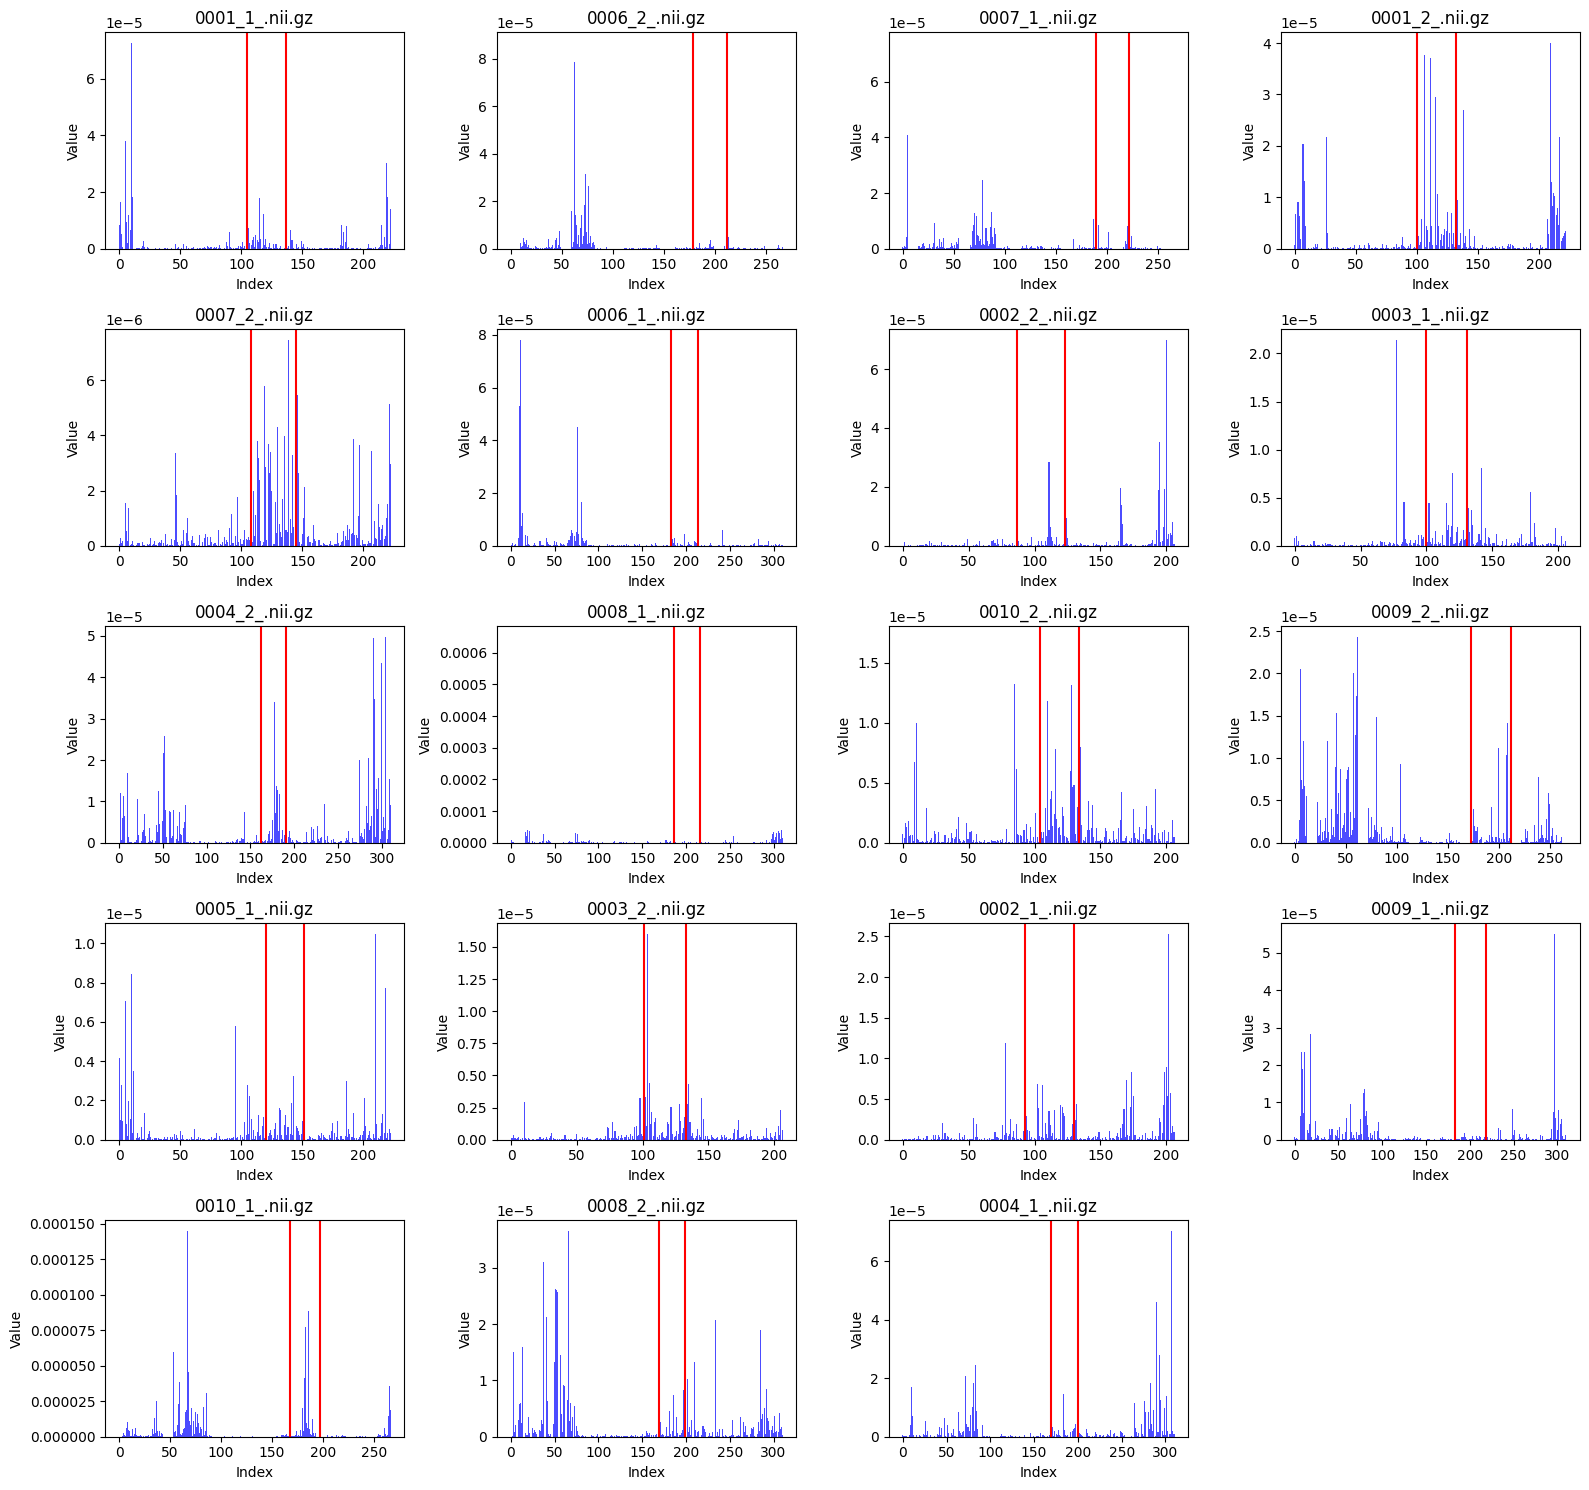

In [192]:
# select_window_of_abdomen(outputs)
# outputs = [output for output, _ in prepared_outputs]
labels = load_labeled_scores('data/oznaczenia.txt')
plot_data = [(prepared_outputs[i][0], labels[prepared_outputs[i][1]][1], labels[prepared_outputs[i][1]][0], prepared_outputs[i][1]) for i in range(len(prepared_outputs))]
plot_graph(plot_data)